In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy

import numpy as np
import tensorflow as tf
import pathlib 
from tensorflow import keras
from tensorflow.keras import layers
import sys, os,io,re, csv, codecs


#spacy.load('en_core_web_sm')
from spacy.lang.en.stop_words import STOP_WORDS
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Nous cahrgeons les fichiers: 
df_train = pd.read_csv('/content/train.csv')
df_test = pd.read_csv('/content/test.csv')
sample_submission = pd.read_csv('/content/sample_submission.csv')

In [ ]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
df_train.shape

(7613, 5)

In [ ]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [ ]:
# on va supprimer la colonne id qui n'est pas nécessaire pour l'analyse 
df_train.drop(columns="id", axis = 1, inplace = True)
df_train.head()

,keyword,location,text,target
0,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
#On vérifie s'il y a des doublons dans les enregistrements 
duplicates_record = df_train[df_train.duplicated(subset=['text'], keep=False)] #subset nous permet d'identifier la colonne dans laquelle on veut 
# chercher les doublons, keep = false il va nous afficher les doublons en true 
duplicates_record

,keyword,location,text,target
40,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http:/...,0
48,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http:/...,0
106,aftershock,US,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...,0
115,aftershock,US,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...,0
118,aftershock,Switzerland,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/TH...,0
...,...,...,...,...
7600,NaN,NaN,Evacuation order lifted for town of Roosevelt:...,1
7607,NaN,NaN,#stormchase Violent Record Breaking EF-5 El Re...,1
7609,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1


In [ ]:
#Environ 179 enregistrements en double sont trouvés. Considérons maintenant (Texte, cible) et ne gardons que le premier
#enregistrement de l'enregistrement en double et supprimez le reste
df_train.drop_duplicates(subset = ['text','target'], keep = 'first', inplace = True, ignore_index = True)
duplicates_record = df_train[df_train.duplicated(subset=['text'], keep=False)]# on refait encore une fois duplicate pr voir s'il nous reste d'autres doublons 
duplicates_record

,keyword,location,text,target
606,bioterrorism,NaN,To fight bioterrorism sir.,1
620,bioterrorism,NaN,To fight bioterrorism sir.,0
1190,buildings%20burning,"Mackay, QLD, Australia",Mmmmmm I'm burning.... I'm burning buildings I...,1
1207,buildings%20burning,"Epic City, BB.",I Pledge Allegiance To The P.O.P.E. And The Bu...,0
1214,buildings%20burning,dallas,like for the music video I want some real acti...,1
1323,burning%20buildings,"Mackay, QLD, Australia",Mmmmmm I'm burning.... I'm burning buildings I...,0
1337,burning%20buildings,dallas,like for the music video I want some real acti...,0
1351,burning%20buildings,"Epic City, BB.",I Pledge Allegiance To The P.O.P.E. And The Bu...,1
2802,displaced,Pedophile hunting ground,.POTUS #StrategicPatience is a strategy for #G...,1
2803,displaced,Pedophile hunting ground,.POTUS #StrategicPatience is a strategy for #G...,0


In [ ]:
duplicates_record.shape

(36, 4)

In [ ]:
#Il existe encore  divers enregistrements en doublon disponibles, mais avec une différence, 
#cette fois pour le même tweet une cible temporelle est 0 et pour une autre elle est 1. Cela semble être des 
#enregistrements corrompus et le modèle NLP peut être confus, il est donc préférable de supprimer ces enregistrements
df_train=df_train.drop_duplicates(subset = ['text'], keep = False, ignore_index = True)# ici on a utilisé le keep Flase pour
# dire on supprime tous les doublons 
df_train

,keyword,location,text,target
0,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...
7480,NaN,NaN,#WorldNews Fallen powerlines on G:link tram: U...,1
7481,NaN,NaN,on the flip side I'm at Walmart and there is a...,1
7482,NaN,NaN,Suicide bomber kills 15 in Saudi security site...,1
7483,NaN,NaN,Two giant cranes holding a bridge collapse int...,1


In [ ]:
df_train.shape

(7485, 4)

In [ ]:
#il est intéressant de vérifier s'il ya des valeurs manquantes: on constate pour les 2 vles qui nous intéressent text,target y en a pas 
df_train.isna().sum()

keyword       56
location    2472
text           0
target         0
dtype: int64

In [ ]:
df_train=df_train[~df_train['location'].isna()]
df_train.head()
# Je décide de travailler uniquement avec les tweets où la géo-localisation est mentionnée 

,keyword,location,text,target
31,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1
32,ablaze,Est. September 2012 - Bristol,We always try to bring the heavy. #metal #RT h...,0
33,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1
34,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0
35,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0


In [ ]:
df_train.shape

(5013, 4)

In [ ]:
df_train.isna().sum()

keyword     0
location    0
text        0
target      0
dtype: int64

In [ ]:
df_train["keyword"].value_counts()

collision                36
whirlwind                33
fatalities               32
armageddon               32
outbreak                 31
                         ..
threat                   10
epicentre                 9
detonation                8
radiation%20emergency     6
inundation                5
Name: keyword, Length: 221, dtype: int64

In [ ]:
df_train['target'].value_counts()
#la target est divisé d'une manière proportionnelle c'est une bonne chose

0    2863
1    2150
Name: target, dtype: int64

In [ ]:
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
df_test.drop(columns="id", axis = 1, inplace = True)

In [ ]:
df_test.shape

(3263, 3)

In [ ]:
#On vérifie s'il y a des doublons dans les enregistrements dans le test 
duplicates_record = df_test[df_test.duplicated(subset=['text'], keep=False)] #subset nous permet d'identifier la colonne dans laquelle on veut 
# chercher les doublons, keep = false il va nous afficher les doublons en true 
duplicates_record.head()

,keyword,location,text
47,aftershock,Switzerland,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/TH...
53,aftershock,Switzerland,320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/TH...
128,apocalypse,NaN,#AskConnor there's a zombie apocalypse. the it...
285,bioterrorism,NaN,To fight bioterrorism sir.
286,bioterrorism,NaN,To fight bioterrorism sir.


In [ ]:
duplicates_record.shape

(39, 3)

In [ ]:
#Environ 39 enregistrements en double sont trouvés, on garde que le premier enregistrement et on supprime le reste 
df_test.drop_duplicates(subset = ['text'], keep = 'first',inplace = True, ignore_index = True)

In [ ]:
df_test.shape

(3243, 3)

In [ ]:
df_test.isna().sum()

keyword       26
location    1097
text           0
dtype: int64

In [ ]:
df_test=df_test[~df_test['location'].isna()]
df_test.head()

,keyword,location,text
15,ablaze,London,Birmingham Wholesale Market is ablaze BBC News...
16,ablaze,Niall's place | SAF 12 SQUAD |,@sunkxssedharry will you wear shorts for race ...
17,ablaze,NIGERIA,#PreviouslyOnDoyinTv: Toke MakinwaÛªs marriag...
18,ablaze,Live On Webcam,Check these out: http://t.co/rOI2NSmEJJ http:/...
19,ablaze,"Los Angeles, Califnordia",PSA: IÛªm splitting my personalities.\n\n?? t...


In [ ]:
df_test.shape

(2146, 3)

In [ ]:
df_test.isna().sum()

keyword     0
location    0
text        0
dtype: int64

I - **Visualization**

Text(0.5, 1.0, 'Distribution of target')

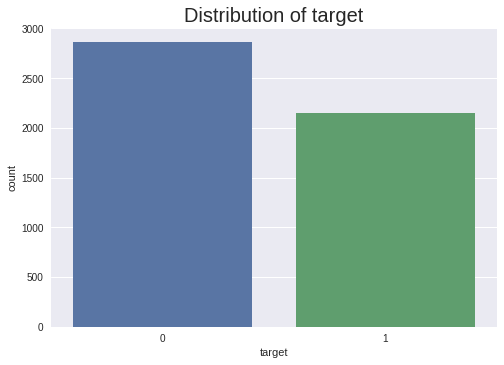

In [ ]:
# Visualisation de la distribution de la cible 
plt.style.use('seaborn')
sns.countplot(df_train['target'])
plt.title('Distribution of target', fontsize=20)

In [ ]:
df_train['keyword'].value_counts()[0:20]

collision           36
whirlwind           33
fatalities          32
armageddon          32
outbreak            31
sandstorm           31
emergency%20plan    31
flames              31
derailed            31
earthquake          30
danger              30
desolation          30
harm                30
damage              30
inundated           30
upheaval            30
rainstorm           29
flattened           29
weapons             29
sinkhole            29
Name: keyword, dtype: int64

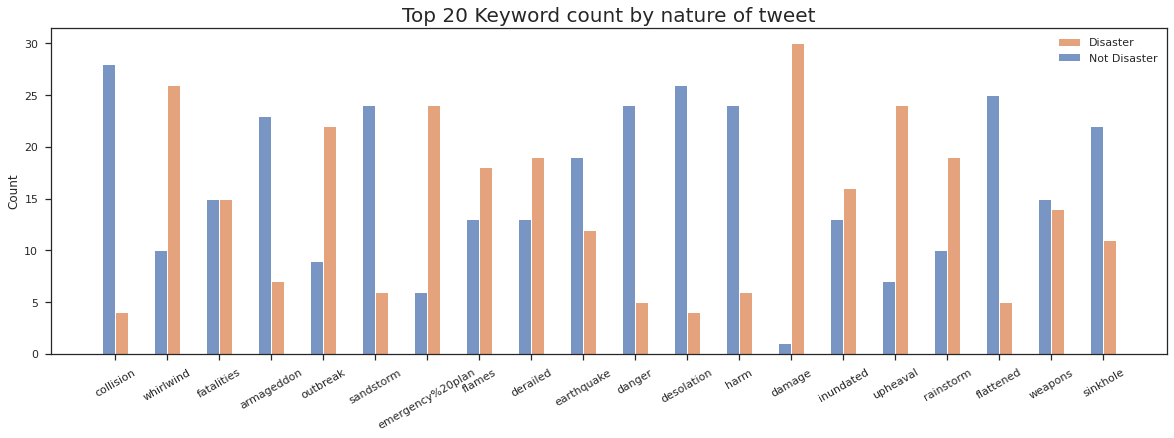

In [ ]:
#Let's take the 20 most frequent keywords
top20 = df_train['keyword'].value_counts()[0:20].index.tolist()
#We take all the keywords and targets if they are in the top20 list
df_top20 = [(keyword,target) for keyword,target in zip(df_train['keyword'], df_train['target']) if keyword in top20]
df_top20 = pd.DataFrame(df_top20, columns = ['keyword', 'target'])

#We plot the results to see the impact of keywords on target
sns.set_theme(style="ticks")
fig, ax = plt.subplots(1,1, figsize = (20,6))
g = sns.histplot(data = df_top20, x = 'keyword', hue = 'target', multiple = 'dodge', shrink = 0.5, ax = ax)
g.set_xticklabels(labels = top20, rotation=30)
g.set_xlabel('')
g.set_title('Top 20 Keyword count by nature of tweet', fontsize=20)
g.legend(['Disaster','Not Disaster'],loc="upper right")

plt.show()

In [ ]:
#Comme nous pouvons le voir, certains mots-clés sont plus fréquemment utilisés pour décrire les catastrophes que d'autres
#Jetons maintenant un coup d'œil à la colonne d'emplacement

In [ ]:
df_train['location'].value_counts()[0:20]

USA                104
New York            71
United States       50
London              45
Canada              29
UK                  26
Los Angeles, CA     26
Nigeria             23
India               21
Washington, DC      21
Mumbai              20
Kenya               20
Worldwide           19
Chicago, IL         18
Australia           18
California          17
New York, NY        15
California, USA     15
Everywhere          15
Florida             14
Name: location, dtype: int64

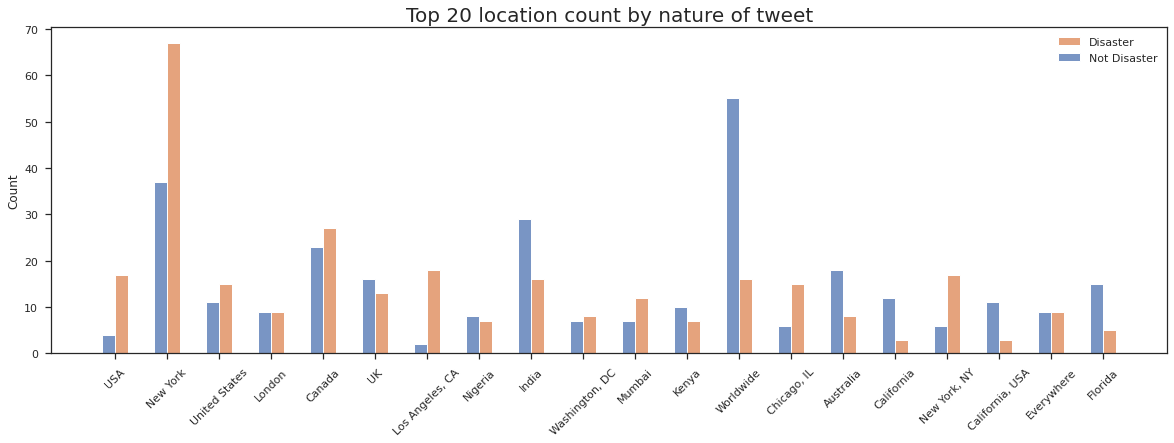

In [ ]:
#Let's take the rest of the 20 most frequent keywords
top20 = df_train['location'].value_counts()[0:20].index.tolist()
#We take all the locations and targets if they are in the top20 list
df_top20 = [(location,target) for location,target in zip(df_train['location'], df_train['target']) if location in top20]
df_top20 = pd.DataFrame(df_top20, columns = ['location', 'target'])

sns.set_theme(style="ticks")

fig,ax = plt.subplots(1,1, figsize = (20,6))

g20 = sns.histplot(data = df_top20, x = 'location', hue = 'target', multiple = 'dodge', shrink = 0.5, ax = ax)
g20.set_xticklabels(labels = top20, rotation=45)
g20.set_xlabel('')
g20.set_title('Top 20 location count by nature of tweet', fontsize=20)
g20.legend(['Disaster','Not Disaster'],loc="upper right")

plt.show()

In [ ]:
#L'emplacement n'est pas cohérent comme nous pouvons le voir par exemple "USA" et "United States" ou "California" et "California, USA",
#étant utilisés en même temps, nous devrons peut-être le nettoyer un peu si nous voulons l'utiliser.

II- Nettoyage de la colonne localisation 

In [ ]:
#On va sélectionner la localisation unique 
pd.DataFrame(df_train['location'].unique(), columns=['location']).sort_values(by='location')

,location
2999,
3314,Glasgow
928,"Melbourne, Australia"
1368,News
1800,å_
...,...
1981,å_: ?? ÌÑ ? : ?
3022,å_å_Los Mina Cityã¢
3082,å¡å¡Midwest Û¢Û¢
3156,åÊ(?Û¢`?Û¢å«)??


In [ ]:
#Après avoir vu qu'il y a des doublons, des mots mal orthographiés, l'utilisation d'abréviations et d'autres choses conduisant à des incohérences, essayons de nettoyer au mieux. 
#Je vais ensuite créer une fonction en utilisant regex

In [ ]:
   def correct_location(x):
    #special char
    x = re.sub(r"United States", "USA", x)
    x = re.sub(r"America", "USA", x)
    x = re.sub(r"America [|] New Zealand ", "USA", x)
    x = re.sub(r"Americas Newsroom", "USA", x)
    x = re.sub(r"us", "USA", x)
    x = re.sub(r"us-east-1a", "USA", x)

    x = re.sub(r"Los Angeles, CA", "Los Angeles", x)
    x = re.sub(r"Chicago, IL", "Chicago", x)

    x = re.sub(r"Boston MA", "Boston", x)
    x = re.sub(r"Boston [\]x89Û¢ Cape Cod [?]", "Boston", x)
    x = re.sub(r"Boston, MA", "Boston", x)
    x = re.sub(r"Boston, Massachusetts", "Boston", x)
    x = re.sub(r"Boston/Montreal ", "Boston", x)

    x = re.sub(r"Birmingham [&] Bristol", "Birmingham", x)
    x = re.sub(r"Birmingham UK", "Birmingham", x)
    x = re.sub(r"Birmingham and the Marches", "Birmingham", x)
    x = re.sub(r"Birmingham, England", "Birmingham", x)
    x = re.sub(r"Birmingham, UK ", "Birmingham", x)
    x = re.sub(r"Birmingham, United Kingdom", "Birmingham", x)

    x = re.sub(r"California, USA", "California", x)
    x = re.sub(r"California, United States", "California", x)
    x = re.sub(r"California or Colorado", "California", x)
    

    x = re.sub(r"New York, NY", "New York", x)
    x = re.sub(r"New York City", "New York", x)
    x = re.sub(r"New York, USA", "New York", x)
    x = re.sub(r"NY", "New York", x)
    x = re.sub(r"new york", "New York", x)
    x = re.sub(r"nc", "New York", x)
    x = re.sub(r"nyc", "New York", x)

    x = re.sub(r"Florida Forever", "Florida", x)
    x = re.sub(r"Florida USA", "Florida", x)
    x = re.sub(r"Florida but I wanna be n Texas", "Florida", x)
    x = re.sub(r"Florida, USA", "Florida", x)
    x = re.sub(r"Florida, USA", "Florida", x)

    x = re.sub(r"Dallas, TX", "Dallas", x)
    x = re.sub(r"Dallas, TX ", "Dallas", x)
    x = re.sub(r"Dallas, Tejas", "Dallas", x)
    x = re.sub(r"Dallas, Texas[.] ", "Dallas", x)

    x = re.sub(r"England ", "England", x)
    x = re.sub(r"England [&] Wales Border, UK", "England", x)
    x = re.sub(r"England, Great Britain[.]", "England", x)
    x = re.sub(r"England, United Kingdom", "England", x)
    x = re.sub(r"England,UK,Europe,Sol 3[.]", "England", x)
    x = re.sub(r"England[.]", "England", x)
    x = re.sub(r"English Midlands", "England", x)

    x = re.sub(r"Texas, USA", "Texas", x)
    x = re.sub(r"Lagos, Nigeria", "Nigeria", x)
    x = re.sub(r"Nxgerxa", "Lagos", x)

    x = re.sub(r"Tampa, FL", "Tampa", x)
    x = re.sub(r"Florida, USA", "Florida", x)
    x = re.sub(r"Asheville, NC", "Asheville", x)
    x = re.sub(r"Oklahoma City, OK ", "Oklahoma City", x)

    x = re.sub(r"Melbourne, Australia", "Australia", x)
    x = re.sub(r"Adelaide", "Australia", x)
    x = re.sub(r"Adelaide, Australia, Australia", "Australia", x)
    x = re.sub(r"Adelaide, South Australia", "Australia", x)
    x = re.sub(r"Australia ", "Australia", x)
    x = re.sub(r"Australian Capital Territory", "Australia", x)

    x = re.sub(r"Bangalore City, India", "Bangalore", x)
    x = re.sub(r"Bangalore, INDIA", "Bangalore", x)
    x = re.sub(r"Bangalore, India", "Bangalore", x)
    x = re.sub(r"Bangalore[.] India", "Bangalore", x)

    x = re.sub(r"Mumbai \(India\)", "Mumbai", x)
    x = re.sub(r"Mumbai india", "Mumbai", x)
    x = re.sub(r"Bangalore[.] India", "Mumbai", x)
    x = re.sub(r"Bangalore[.] India", "Mumbai", x)

    x = re.sub(r"Washington, DC", "Washington", x)
    x = re.sub(r"Washington, D[.]C[.]", "Washington", x)
    x = re.sub(r"Washington, D[.]C[.]", "Washington", x)
    x = re.sub(r"Washington [&] Charlotte", "Washington", x)
    x = re.sub(r"Washington 20009", "Washington", x)
    x = re.sub(r"Washington D[.]C[.]", "Washington", x)
    x = re.sub(r"Washington DC", "Washington", x)
    x = re.sub(r"Washington DC [/] Nantes", "Washington", x)
    x = re.sub(r"Washington NATIVE", "Washington", x)
    x = re.sub(r"Washington State", "Washington", x)
    x = re.sub(r"Washington state", "Washington", x)

    x = re.sub(r"San Francisco, CA", "San Francisco", x)

    x = re.sub(r"London, UK", "London", x)
    x = re.sub(r"London, England", "London", x)
    x = re.sub(r"London / Berlin / Online", "London", x)
    x = re.sub(r"London UK", "London", x)
    x = re.sub(r"London[.]", "London", x)
    x = re.sub(r"London/Bristol/Guildford", "London", x)
    x = re.sub(r"London/Lagos/FL ÌÏT: 6[.]6200132", "London", x)
    x = re.sub(r"London/New York", "London", x)
    x = re.sub(r"London/Outlaw Country", "London", x)
    x = re.sub(r"London/Surrey", "London", x)

    x = re.sub(r"Atlanta, GA", "Atlanta", x)
    x = re.sub(r"Atlanta [-] FAU class of '18", "Atlanta", x)
    x = re.sub(r"Atlanta Georgia", "Atlanta", x)
    x = re.sub(r"Atlanta Georgia ", "Atlanta", x)
    x = re.sub(r"Atlanta g[.]a[.]", "Atlanta", x)
    x = re.sub(r"Atlanta[(]ish[)], GA", "Atlanta", x)
    x = re.sub(r"Atlanta, Ga", "Atlanta", x)
    x = re.sub(r"Atlanta, Georgia", "Atlanta", x)
    x = re.sub(r"Atlanta, Georgia USA", "Atlanta", x)
    x = re.sub(r"Atlanta,Ga", "Atlanta", x)
    x = re.sub(r"Atlanta ", "Atlanta", x)
    x = re.sub(r"Atlanta USA", "Atlanta", x)
    x = re.sub(r"Atlanta[(]ish[)]", "Atlanta", x)
    x = re.sub(r"Atlanta,Ga", "Atlanta", x)

    x = re.sub(r"Sacramento, CA", "Sacramento", x)

    x = re.sub(r"Nashville, TN", "Nashville", x)
    x = re.sub(r"Denver, Colorado", "Denver", x)
    x = re.sub(r"Dallas, TX", "Dallas", x)
    x = re.sub(r"Houston, TX", "Houston", x)
    x = re.sub(r"Seattle, WA", "Seattle", x)
    x = re.sub(r"Pennsylvania, USA, WA", "Pennsylvania", x)
    x = re.sub(r"Memphis, TN", "Memphis", x)
    x = re.sub(r"Austin, TX", "Austin", x)
    x = re.sub(r"Austin TX", "Austin", x)
    x = re.sub(r"Austin [|] San Diego", "Austin", x)
    x = re.sub(r"Austin/Los Angeles", "Austin", x)

    x = re.sub(r"Portland, OR", "Portland", x)

    x = re.sub(r"Charlotte, NC", "Charlotte", x)
    x = re.sub(r"Charlotte ", "Charlotte", x)
    x = re.sub(r"Charlotte County Florida", "Charlotte", x)
    x = re.sub(r"Charlotte, N[.]C[.]", "Charlotte", x)
    x = re.sub(r"Charlotte, NC [|] KÌ¦ln, NRW", "Charlotte", x)
    x = re.sub(r"Charlotte, North Carolina", "Charlotte", x)
    x = re.sub(r"CharlotteCounty Florida", "Charlotte", x)
    x = re.sub(r"CharlotteNC", "Charlotte", x)
    x = re.sub(r"Charlottetown", "Charlotte", x)
    x = re.sub(r"Charlotte[|]Charlotte", "Charlotte", x)

    x = re.sub(r"Brooklyn, NY", "Brooklyn", x)

    x = re.sub(r"Brasil, Fortaleza ce", "Brazil", x)
    x = re.sub(r"Brasil,SP", "Brazil", x)
    x = re.sub(r"BrasÌ_lia", "Brazil", x)
    x = re.sub(r"Brazil", "Brazil", x)
    x = re.sub(r"Brazil ", "Brazil", x)

    x = re.sub(r"Calgary, Alberta", "Calgary", x)
    x = re.sub(r"Calgary, AB", "Calgary", x)
    x = re.sub(r"Calgary, AB, Canada", "Calgary", x)
    x = re.sub(r"Calgary/Airdrie/RedDeer/AB", "Calgary", x)
    x = re.sub(r"Calgary,AB, Canada", "Calgary", x)
    x = re.sub(r"Calgary, Canada", "Calgary", x)
    x = re.sub(r"Calgary, Alberta, Canada", "Calgary", x)
    x = re.sub(r"MontrÌ©al", "Montreal", x)
   
    x = re.sub(r"Alberta ", "Alberta", x)
    x = re.sub(r"Alberta Pack", "Alberta", x)
    x = re.sub(r"Alberta Pack", "Alberta", x)
    x = re.sub(r"Alberta [|] Sask[.] [|] Montana", "Alberta", x)

    x = re.sub(r"Morioh, Japan", "Japan", x)
    x = re.sub(r"Orlando, FL ", "Orlando", x)
    x = re.sub(r"Portland, OR", "Portland", x)
   
    x = re.sub(r"Afghanistan, USA", "Afghanistan", x)
    x = re.sub(r"Abuja", "Abuja", x)
    x = re.sub(r"Abuja,Nigeria", "Abuja", x)
    x = re.sub(r"Abuja", "Nigeria", x)

    x = re.sub(r"Alabama, USA", "Alabama", x)
    x = re.sub(r"Alameda and Pleasanton, CA", "Alameda", x)
    x = re.sub(r"Alameda, CA", "Alameda", x)

    x = re.sub(r"Alaska, USA", "Alaska", x)

    x = re.sub(r"Albuquerque New Mexico", "Albuquerque", x)

    x = re.sub(r"Alexandria, VA", "Alexandria", x)
    x = re.sub(r"Alexandria, VA, USA", "Alexandria", x)

    x = re.sub(r"All around the world", "worldwide!", x)
    x = re.sub(r"All around the world", "worldwide!", x)
    x = re.sub(r"All around the world baby", "worldwide!", x)
    x = re.sub(r"All around the world[!]", "worldwide!", x)
    x = re.sub(r"All Around the World baby", "worldwide!", x)
    x = re.sub(r"All Around the World[!]", "worldwide!", x)

    x = re.sub(r"Alicante, Spain", "Alicante", x)
    x = re.sub(r"Alicante, Valencia", "Alicante", x)

    return x

In [ ]:
#Nous effectuerons simultanément les changements sur le train et sur le test pour faciliter les prochaines parties de l'étude:

#on train
df_train['location_clean']=df_train['location'].apply(lambda x: correct_location(x))
print(df_train['location_clean'].tail(25))

#on test
df_test['location_clean'] = df_test['location'].apply(lambda x: correct_location(x))

7418                New Delhi,India
7419                   Xi'an, China
7420                         Mumbai
7421             Brooklyn, New York
7422           Robin Hood's County 
7424                            USA
7425                   Pennsylvania
7429                 Santa Cruz, CA
7432               Milwaukee County
7433    Click the link below, okay 
7435              probably not home
7438                              6
7443                            USA
7444                   At your back
7446                 Livingston, MT
7447                     California
7448                       Glasgow 
7449            Manhattan, New York
7450                  Denton, Texas
7451                         Global
7452                             TN
7454         #NewcastleuponTyne #UK
7456        VaNew Yorkouver, Canada
7457                        London 
7458                  LiNew Yorkoln
Name: location_clean, dtype: object


In [ ]:
#on train

#Il y a certaines villes qui s'écrivent ainsi : "New York City, US" on sépare avant et après la virgule et on ne garde que la première partie "New york City"
df_train['location_clean']=df_train['location_clean'].apply(lambda x: x.split(',')[0])
#Idem avec le point
df_train['location_clean']=df_train['location_clean'].apply(lambda x: x.split('.')[0])
#On supprime les espaces au début et à la fin 
df_train['location_clean']=df_train['location_clean'].apply(lambda x: x.strip())
#Nous mettons tout en minuscules car nous avons trouvé des doublons en minuscules
df_train['location_clean']=df_train['location_clean'].str.lower()
#Nous ne gardons que les lettres, tous les caractères non alpha sont supprimés, y compris les chiffres
df_train['location_clean']=df_train['location_clean'].apply(lambda x: "".join(ch for ch in x if ch.isalpha() or ch == ' '))
print(df_train['location_clean'].tail(25))

#on test
df_test['location_clean'] = df_test['location_clean'].apply(lambda x: x.split(',')[0])
df_test['location_clean'] = df_test['location_clean'].apply(lambda x: x.split('.')[0])
df_test['location_clean'] = df_test['location_clean'].apply(lambda x: x.strip())
df_test['location_clean'] = df_test['location_clean'].str.lower()
df_test['location_clean'] = df_test['location_clean'].apply(lambda x: "".join(ch for ch in x if ch.isalpha() or ch == ' '))

7418               new delhi
7419                    xian
7420                  mumbai
7421                brooklyn
7422      robin hoods county
7424                     usa
7425            pennsylvania
7429              santa cruz
7432        milwaukee county
7433    click the link below
7435       probably not home
7438                        
7443                     usa
7444            at your back
7446              livingston
7447              california
7448                 glasgow
7449               manhattan
7450                  denton
7451                  global
7452                      tn
7454    newcastleupontyne uk
7456         vanew yorkouver
7457                  london
7458           linew yorkoln
Name: location_clean, dtype: object


In [ ]:
df_train['location_clean'].value_counts()[0:20]

usa                    164
new york               126
london                  85
                        83
washington              56
los angeles             51
california              43
nigeria                 40
chicago                 37
canada                  35
worldwide               33
uk                      31
mumbai                  30
atlanta                 29
san franew yorkisco     26
india                   25
seattle                 23
calgary                 23
florida                 22
toronto                 22
Name: location_clean, dtype: int64

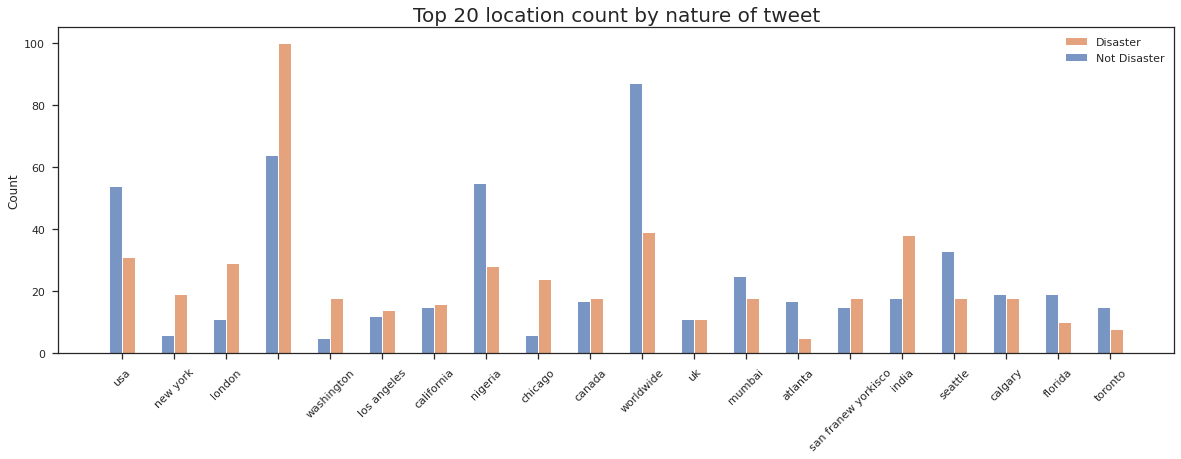

In [ ]:
#Visualisons à nouveau les données
#Let's take the rest of the 20 most frequent keywords
top20 = df_train['location_clean'].value_counts()[0:20].index.tolist()
#We take all the locations and targets if they are in the top20 list
df_top20 = [(location_clean,target) for location_clean,target in zip(df_train['location_clean'], df_train['target']) if location_clean in top20]
df_top20 = pd.DataFrame(df_top20, columns = ['location_clean', 'target'])

sns.set_theme(style="ticks")

fig,ax = plt.subplots(1,1, figsize = (20,6))

g20 = sns.histplot(data = df_top20, x = 'location_clean', hue = 'target', multiple = 'dodge', shrink = 0.5, ax = ax)
g20.set_xticklabels(labels = top20, rotation=45)
g20.set_xlabel('')
g20.set_title('Top 20 location count by nature of tweet', fontsize=20)
g20.legend(['Disaster','Not Disaster'],loc="upper right")

plt.show()

In [ ]:
#Comme on peut le voir les données sont plus propres, mais comme nous l'avons dit plus tôt nous devons nous 
#débarrasser des "non localisés" car il y en a trop, cela va biaiser les données. De plus, il n'est pas très 
#utile de conserver des emplacements qui ne sont utilisés que pour quelques tweets. Nous décidons donc de ne 
#garder que les emplacements qui sont utilisés pour plus de 5 tweets

In [ ]:
#faire la liste des emplacements utilisés moins de 5 fois. Nous supprimerons ensuite ces mots-clés et les "non localisés"
#on train 
mask = df_train['location_clean'].value_counts() <5
under_5 = df_train['location_clean'].value_counts()[mask].index.to_list()
df_train['location_clean'] = df_train['location_clean'].apply(lambda x: '' if x in under_5 or x =="unlocated" else x)
df_train['location_clean']=df_train['location_clean'].replace('', np.nan)
df_train=df_train.dropna(subset=['location_clean'])
print(df_train.tail(5))


#on test
mask = df_test['location_clean'].value_counts() <5
under_5 = df_test['location_clean'].value_counts()[mask].index.to_list()
df_test['location_clean'] = df_test['location_clean'].apply(lambda x: '' if x in under_5 or x =="unlocated" else x)
df_test['location_clean']=df_test['location_clean'].replace('', np.nan)
df_test=df_test.dropna(subset=['location_clean'])

      keyword           location  ... target   location_clean
7447  wrecked         California  ...      0       california
7448  wrecked           Glasgow   ...      0          glasgow
7451  wrecked             Global  ...      0           global
7456  wrecked  Vancouver, Canada  ...      0  vanew yorkouver
7457  wrecked            London   ...      0           london

[5 rows x 5 columns]


In [ ]:
df_train.shape

(1941, 5)

III- Nettoyage du texte

In [ ]:
import spacy
spacy.__version__
!python -m spacy download en_core_web_md -q

     |████████████████████████████████| 96.4 MB 1.4 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [ ]:
# Import English using en_core_web_md.load()
import en_core_web_md
nlp = en_core_web_md.load()
# avec nlp je peux traiter une chaine de caractères 

In [ ]:
# Import Stop words 
from spacy.lang.en.stop_words import STOP_WORDS

In [ ]:
#La tâche suivante consiste à créer une fonction de normalisation de texte spécifique au contenu trouvé dans les tweets. 
#Outre la ponctuation, il existe des URL, des abréviations, des entités, des retweets, des chiffres, des mots vides et bien sûr 
#des emojis. Les mots de chaque tweet seront également lemmatisés ou réduits à leur forme racine à l'aide de la bibliothèque spaCy. 
#Nous allons commencer par créer un dictionnaire de recherche avec des abréviations courantes de phrases Twitter. Les termes de Tweet 
#qui correspondent aux clés du dictionnaire de recherche seront étendus à leur forme non abrégée.
lookup_dict = {
  'abt' : 'about',
  'afaik' : 'as far as i know',
  'bc' : 'because',
  'bfn' : 'bye for now',
  'bgd' : 'background',
  'bh' : 'blockhead',
  'br' : 'best regards',
  'btw' : 'by the way',
  'cc': 'carbon copy',
  'chk' : 'check',
  'dam' : 'do not annoy me',
  'dd' : 'dear daughter',
  'df': 'dear fiance',
  'ds' : 'dear son',
  'dyk' : 'did you know',
  'em': 'email',
  'ema' : 'email address',
  'ftf' : 'face to face',
  'fb' : 'facebook',
  'ff' : 'follow friday', 
  'fotd' : 'find of the day',
  'ftw': 'for the win',
  'fwiw' : 'for what it is worth',
  'gts' : 'guess the song',
  'hagn' : 'have a good night',
  'hand' : 'have a nice day',
  'hotd' : 'headline of the day',
  'ht' : 'heard through',
  'hth' : 'hope that helps',
  'ic' : 'i see',
  'icymi' : 'in case you missed it',
  'idk' : 'i do not know',
  'ig': 'instagram',
  'iirc' : 'if i remember correctly',
  'imho' : 'in my humble opinion',
  'imo' : 'in my opinion',
  'irl' : 'in real life',
  'iwsn' : 'i want sex now',
  'jk' : 'just kidding',
  'jsyk' : 'just so you know',
  'jv' : 'joint venture',
  'kk' : 'cool cool',
  'kyso' : 'knock your socks off',
  'lmao' : 'laugh my ass off',
  'lmk' : 'let me know', 
  'lo' : 'little one',
  'lol' : 'laugh out loud',
  'mm' : 'music monday',
  'mirl' : 'meet in real life',
  'mrjn' : 'marijuana',
  'nbd' : 'no big deal',
  'nct' : 'nobody cares though',
  'njoy' : 'enjoy',
  'nsfw' : 'not safe for work',
  'nts' : 'note to self',
  'oh' : 'overheard',
  'omg': 'oh my god',
  'oomf' : 'one of my friends',
  'orly' : 'oh really',
  'plmk' : 'please let me know',
  'pnp' : 'party and play', 
  'qotd' : 'quote of the day',
  're' : 'in reply to in regards to',
  'rtq' : 'read the question',
  'rt' : 'retweet',
  'sfw' : 'safe for work',
  'smdh' : 'shaking my damn head', 
  'smh' : 'shaking my head',
  'so' : 'significant other',
  'srs' : 'serious',
  'tftf' : 'thanks for the follow',
  'tftt' : 'thanks for this tweet',
  'tj' : 'tweetjack',
  'tl' : 'timeline',
  'tldr' : 'too long did not read',
  'tmb' : 'tweet me back',
  'tt' : 'trending topic',
  'ty' : 'thank you',
  'tyia' : 'thank you in advance',
  'tyt' : 'take your time',
  'tyvw' : 'thank you very much',
  'w': 'with', 
  'wtv' : 'whatever',
  'ygtr' : 'you got that right',
  'ykwim' : 'you know what i mean',
  'ykyat' : 'you know you are addicted to',
  'ymmv' : 'your mileage may vary',
  'yolo' : 'you only live once',
  'yoyo' : 'you are on your own',
  'yt': 'youtube',
  'yw' : 'you are welcome',
  'zomg' : 'oh my god to the maximum'
}


In [ ]:
def abbrev_conversion(text):
    words = text.split() 
    abbrevs_removed = [] 
    
    for i in words:
        if i in lookup_dict:
            i = lookup_dict[i]
        abbrevs_removed.append(i)
            
    return ' '.join(abbrevs_removed)
# on créée une fonction qui nous permet de transformer les phrases abrégées en phrases non abrégées

In [ ]:
#on train 
#pour supprimer les urls 
df_train["text_clean"] = df_train["text"].apply(lambda x: re.sub(re.compile(r'(?:\@|http?\://|https?\://|www)\S+'), '', x) if pd.isna(x) != True else x) 
#On supprimer tous les caractères non alphanumériques à l'exception des espaces 
df_train["text_clean"] = df_train["text_clean"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" "))
#On va transformer ttes les phrases abrégées en non abrgées mais on ne prend pas en compte les NAN.
df_train["text_clean"]= df_train["text_clean"].apply(lambda x: abbrev_conversion(x) if pd.isna(x) != True else x)
#On supprime les doubles espaces et les espaces au début et à la fin des chaînes et on transforme en miniscule
df_train["text_clean"] =df_train["text_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())
#On supprime les mots vides et remplace chaque mot par son lemme
#pour chaque token ds nlp appliqué à x qui représente un élément dans ma colonne on va chercher les lemmas mais
#uniquement si le texte associé à mon token n'est pas ds les stop_words et que le lemma associé à mon token n'est pas dans les stop_words non plus
df_train["text_clean"]= df_train["text_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) and (token.text not in STOP_WORDS)]))
print(df_train.head())

#on test
df_test["text_clean"] = df_test["text"].apply(lambda x: re.sub(re.compile(r'(?:\@|http?\://|https?\://|www)\S+'), '', x) if pd.isna(x) != True else x)  
df_test["text_clean"] = df_test["text_clean"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" "))
df_test["text_clean"]= df_test["text_clean"].apply(lambda x: abbrev_conversion(x) if pd.isna(x) != True else x)
df_test["text_clean"] =df_test["text_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())
df_test["text_clean"]= df_test["text_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) and (token.text not in STOP_WORDS)]))

   keyword  ...                                         text_clean
31  ablaze  ...                            wholesale market ablaze
33  ablaze  ...  africanbaze break newsnigeria flag set ablaze aba
34  ablaze  ...                                     cry set ablaze
35  ablaze  ...                         plus look sky night ablaze
37  ablaze  ...                        inec office abia set ablaze

[5 rows x 6 columns]


In [ ]:
df_train.shape

(1941, 6)

Le modèle prédit si un tweet donné parle d'un véritable désastre ou non. Si oui, il prédit un 1. Sinon, il prédit un 0.

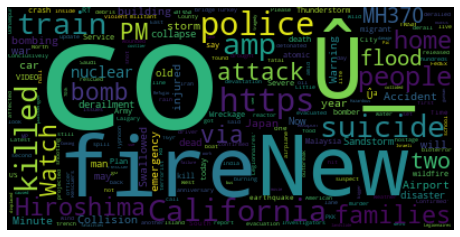

In [ ]:
# Word cloud of text in disaster and non-disaster tweets

# Cleaned dataframe of disaster
df_true = df_train[df_train.target == 1]

text_true = " ".join(txt for txt in df_true['text'])

text_cloud = WordCloud(collocations=False, background_color='black').generate(text_true)
plt.axis("off")
plt.imshow(text_cloud, interpolation='bilinear')

In [ ]:
#Words in disaster tweets:- disaster, new, fire, via, year, suicide, police, home,killed, crash, storm, etc.

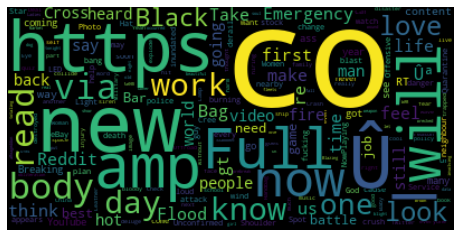

In [ ]:
# Cleaned dataframe of disaster
df_true = df_train[df_train.target == 0]

text_true = " ".join(txt for txt in df_true['text'])

text_cloud = WordCloud(collocations=False, background_color='black').generate(text_true)
plt.axis("off")
plt.imshow(text_cloud, interpolation='bilinear')

In [ ]:
#Words in non-disaster tweets:- new, love, one, time, now, body, people,good, etc.

In [ ]:
import numpy as np
tokenizer = tf.keras.preprocessing.text.Tokenizer() # instanciate the tokenizer pr garder les mots les plus fréquents
tokenizer.fit_on_texts(df_train.text_clean)#il va créer son tableau de correspondance pour remplacer les textes en liste d'indices 
df_train["text_encoded"] = tokenizer.texts_to_sequences(df_train.text_clean)# pour remplacer le texte en liste d'indices 

df_train["len_text"] = df_train["text_encoded"].apply(lambda x: len(x))
df_train= df_train[df_train["len_text"]!=0] 
df_train 

,keyword,location,text,target,location_clean,text_clean,text_encoded,len_text
31,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,birmingham,wholesale market ablaze,"[1059, 165, 316]",3
33,ablaze,AFRICA,#AFRICANBAZE: Breaking news:Nigeria flag set a...,1,africa,africanbaze break newsnigeria flag set ablaze aba,"[2217, 79, 2218, 269, 92, 316, 496]",7
34,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0,philadelphia,cry set ablaze,"[846, 92, 316]",3
35,ablaze,"London, UK",On plus side LOOK AT THE SKY LAST NIGHT IT WAS...,0,london,plus look sky night ablaze,"[2219, 19, 427, 234, 316]",5
37,ablaze,World Wide!!,INEC Office in Abia Set Ablaze - http://t.co/3...,1,world wide,inec office abia set ablaze,"[1424, 589, 1425, 92, 316]",5
...,...,...,...,...,...,...,...,...
7447,wrecked,California,Cramer: Iger's 3 words that wrecked Disney's s...,0,california,cramer igers 3 word wreck disneys stock cnbc t...,"[1058, 1422, 43, 304, 114, 1423, 181, 1822, 5901]",9
7448,wrecked,Glasgow,@Caitsroberts see U the night wee bArra to get...,0,glasgow,u night wee barra absolutely wreck,"[240, 234, 2181, 5902, 5903, 114]",6
7451,wrecked,Global,Cramer: 3 words that wrecked DIS stock - http:...,0,global,cramer 3 word wreck dis stock,"[1058, 43, 304, 114, 5904, 181]",6
7456,wrecked,"Vancouver, Canada",Three days off from work and they've pretty mu...,0,vanew yorkouver,day work pretty wreck hahaha shoutout family,"[21, 18, 1412, 114, 5905, 5906, 16]",7


In [ ]:
#On va nettoyer notre texte à l'aide de spacy puis on va encoder le texte en le transformant en liste d'indices
#pr ceci on utilise le tenserflow tokenizer  

In [ ]:
## On fait de même sur le set de test, sauf qu'on ne fit pas sur le tokenizer 
df_test["text_encoded"] = tokenizer.texts_to_sequences(df_test.text_clean)
df_test["len_text"] =df_test["text_encoded"].apply(lambda x: len(x))
df_test=df_test[df_test["len_text"]!=0] 

In [ ]:
# on rajoute du padding pour avoir la même longueur dans tte les phrase 
train_pad = tf.keras.preprocessing.sequence.pad_sequences(df_train.text_encoded, padding="post")
test_pad = tf.keras.preprocessing.sequence.pad_sequences(df_test.text_encoded, padding="post")

In [ ]:
seed=123 # pr avoir le mm comportement qui se reproduit à chaque fois c'est comme un random state
train_x, val_x, train_y, val_y = train_test_split(
    train_pad,
    df_train.target,
    test_size=0.2,
    random_state=seed
)

print(train_x.shape)
print(train_y.shape)
print(val_x.shape)
print(val_y.shape)

(1552, 25)
(1552,)
(388, 25)
(388,)


In [ ]:
 # on transforme notre dataset en jeu de données tensoriel dans lequel on va mettre un tuple (1 er éléméent nos données, 2ème élément notre vble cible ) 
train_ds = tf.data.Dataset.from_tensor_slices((train_x, train_y))
val_ds=tf.data.Dataset.from_tensor_slices((val_x, val_y))
test_ds = tf.data.Dataset.from_tensor_slices(test_pad)

In [ ]:
next(iter(train_ds))
# c'est un élément de mon tenseur dataset j'ai une séquence de 25 mots avec plein de 0 padding et un tenseur qui 
# contient ma vble cible 

(<tf.Tensor: shape=(25,), dtype=int32, numpy=
 array([ 193, 1523,  333, 1524,  873,  155,   99, 1525, 1526,   27,  217,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0], dtype=int32)>,
 <tf.Tensor: shape=(), dtype=int64, numpy=1>)

In [ ]:
train_ds = train_ds.shuffle(len(train_ds)).batch(64)
val_ds=val_ds.shuffle(len(val_ds)).batch(64)
test_ds = test_ds.batch(64)
# on applique le shuffle pr qu'à la fin de chaque époque les données se remélangent et on les organisent par
# batch de 64 phrases 

In [ ]:
len(tokenizer.word_index)

5909

IV-**Modeling**

In [ ]:
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, GRU, LSTM,GlobalAveragePooling1D, Dropout

In [ ]:
# c'est le nbre de mots qu'on a séléctionné dans notre tokenizer 
vocab_size=len(tokenizer.word_index)
model = tf.keras.Sequential([
                  # Couche d'Input Word Embedding(chaque indice va être représenté par un vecteur pour avoir une représentation plus riche qui nous donnera la possibilité d'analyser plus finement les mots de nos textes)         
                  tf.keras.layers.Embedding(vocab_size+1, 8, input_shape=[train_pad.shape[1],],name="embedding"), # chaque mot va être représeenté par un vecteur de 8 valeurs
                  # Gobal average pooling
                  tf.keras.layers.GlobalAveragePooling1D(),# pr supprimer la dimension séquentielle, il va faire un résumer

                  # Couche Dense classique
                  tf.keras.layers.Dense(16, activation='relu'),
                  tf.keras.layers.Dense(8, activation='relu'),

                  # Couche de sortie avec le nombre de neurones en sortie égale au nombre de classe avec fonction softmax
                  tf.keras.layers.Dense(1, activation="sigmoid") # c'est la couche de prédiction avec une classification binaire 
])
# input_dim c'est le nbre de mot utilisé et input shape c'est le nbr de mots dans mes phrases, la longueur de mes phrases 

In [ ]:
model.summary()
# None c'est la batch size 25 mots par phrases et chaque est représenté par 32 valeurs, on fait le GA on se
# retrouve avec 8 valeurs 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 8)             47280     
                                                                 
 global_average_pooling1d (G  (None, 8)                0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 16)                144       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 1)                 9         
                                                                 
Total params: 47,569
Trainable params: 47,569
Non-trainable params: 0
____________________________________________________

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
# Vu qu'on est en classification 

In [ ]:
# Entrainement du modèle 
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=20, 
                  )

Epoch 1/20
25/25 [==============================] - 2s 21ms/step - loss: 0.6925 - accuracy: 0.5387 - val_loss: 0.6928 - val_accuracy: 0.5052
Epoch 2/20
25/25 [==============================] - 0s 8ms/step - loss: 0.6898 - accuracy: 0.5387 - val_loss: 0.6909 - val_accuracy: 0.5052
Epoch 3/20
25/25 [==============================] - 0s 7ms/step - loss: 0.6833 - accuracy: 0.5696 - val_loss: 0.6847 - val_accuracy: 0.5722
Epoch 4/20
25/25 [==============================] - 0s 10ms/step - loss: 0.6683 - accuracy: 0.7094 - val_loss: 0.6721 - val_accuracy: 0.7113
Epoch 5/20
25/25 [==============================] - 0s 10ms/step - loss: 0.6398 - accuracy: 0.8550 - val_loss: 0.6494 - val_accuracy: 0.7835
Epoch 6/20
25/25 [==============================] - 0s 7ms/step - loss: 0.5936 - accuracy: 0.9066 - val_loss: 0.6179 - val_accuracy: 0.7655
Epoch 7/20
25/25 [==============================] - 0s 4ms/step - loss: 0.5280 - accuracy: 0.9265 - val_loss: 0.5783 - val_accuracy: 0.8015
Epoch 8/20
25/25 

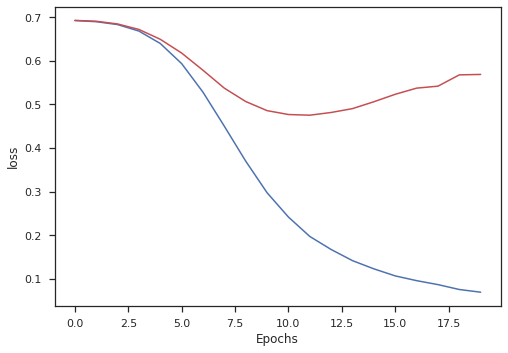

In [ ]:
import matplotlib.pyplot as plt

# Visualization of the training process on the loss function 
plt.plot(history.history["loss"], color="b")
plt.plot(history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()


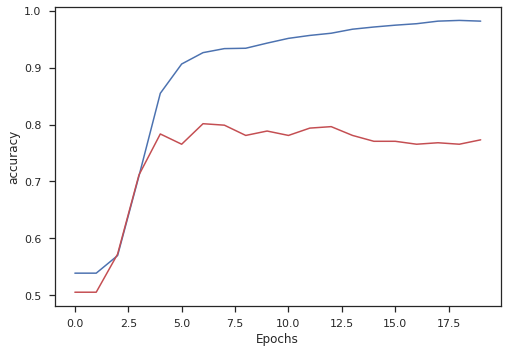

In [ ]:
# Visualization of accuracy training 
plt.plot(history.history["accuracy"], color="b")
plt.plot(history.history["val_accuracy"], color="r")
plt.ylabel("accuracy")
plt.xlabel("Epochs")
plt.show()

In [ ]:
# La faiblesse des neuronnes dense pr analyser des séquences c'est qu'il traite chaque mot de manière indépendante
# l'information d'un mot n'influence pas l'autre mot   

In [ ]:
vocab_size=len(tokenizer.word_index)
model = tf.keras.Sequential([
                  # Word Embedding layer           
                  Embedding(vocab_size+1,64, input_shape=[train_pad.shape[1],],name="embedding"),
                  SimpleRNN(units=32, return_sequences=False), # returns the last output
                  # Dense layers once the data is flat
                  Dense(16, activation='relu'),
                  # output layer with as many neurons as the number of classes
                  # for the target variable and softmax activation
                  Dropout(0.5),
                  Dense(1, activation="sigmoid")
])
#le choix de la sigmoid parce que notre target va avoir deux valeurs 0 ou 1 s'il y a catastrophe 
# vocab_size c'est le nbre de mot dont on dispose +1 pr le padding 
# input_shape : le nombre max de mot dans la phrase 

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 64)            378240    
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 32)                3104      
                                                                 
 dense_9 (Dense)             (None, 16)                528       
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_10 (Dense)            (None, 1)                 17        
                                                                 
Total params: 381,889
Trainable params: 381,889
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam', # c'est l'algorithme de descente de gradient spécifique qu'on veut choisir pr l'entraîner
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
# Entrainement du modèle 
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=20, 
                  )

Epoch 1/20
25/25 [==============================] - 2s 26ms/step - loss: 0.6889 - accuracy: 0.5303 - val_loss: 0.6784 - val_accuracy: 0.5902
Epoch 2/20
25/25 [==============================] - 0s 16ms/step - loss: 0.5525 - accuracy: 0.7803 - val_loss: 0.5711 - val_accuracy: 0.7216
Epoch 3/20
25/25 [==============================] - 0s 17ms/step - loss: 0.2491 - accuracy: 0.9446 - val_loss: 0.6560 - val_accuracy: 0.7036
Epoch 4/20
25/25 [==============================] - 0s 18ms/step - loss: 0.1312 - accuracy: 0.9736 - val_loss: 0.7504 - val_accuracy: 0.7113
Epoch 5/20
25/25 [==============================] - 0s 17ms/step - loss: 0.0929 - accuracy: 0.9807 - val_loss: 0.8306 - val_accuracy: 0.7062
Epoch 6/20
25/25 [==============================] - 0s 17ms/step - loss: 0.0616 - accuracy: 0.9858 - val_loss: 0.9633 - val_accuracy: 0.6933
Epoch 7/20
25/25 [==============================] - 0s 16ms/step - loss: 0.0544 - accuracy: 0.9832 - val_loss: 1.0004 - val_accuracy: 0.7010
Epoch 8/20
25

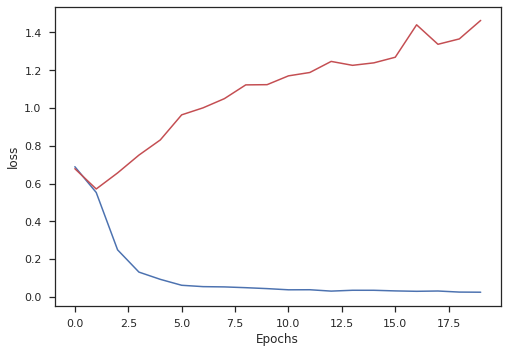

In [ ]:
import matplotlib.pyplot as plt

# Visualization of the training process on the loss function 
plt.plot(history.history["loss"], color="b")
plt.plot(history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()
# comme le schéma le montre on commence à overfitter depuis le début la val loss n'arrête pas d'augmenter 

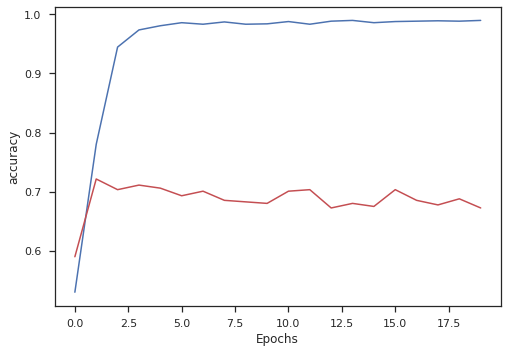

In [ ]:
# Visualization of accuracy training 
plt.plot(history.history["accuracy"], color="b")
plt.plot(history.history["val_accuracy"], color="r")
plt.ylabel("accuracy")
plt.xlabel("Epochs")
plt.show()

In [ ]:
# L'inconvenient du SRNN c'est qu'il n'est pas efficace sur les phrases longues, la fonction d'activation qu'on utilise 
# le plus souvent c'est une tangente hyperbolique comme on va dérivé plusieurs tangente hyperbolique qui va être comprise
# entre 0 et 1 donc plus on va multilplier les dérivés plus on va réduire la valeur du gradient, on va avoir un problème
# de vanishing gradient on va avoir bcp de mal à entrainer le modèle et donc a bien prédire


In [ ]:
model.save("model_simpleRNN.h5")

In [ ]:
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, GRU, LSTM

vocab_size=len(tokenizer.word_index)
model_gru = tf.keras.Sequential([
                  Embedding(vocab_size+1,64, input_shape=[train_pad.shape[1],],name="embedding"),
                  GRU(units=32, return_sequences=True), # maintains the sequential nature
                  tf.keras.layers.Bidirectional(GRU(units=16, return_sequences=False)), # returns the last output
                  Dense(16, activation='relu'),
                  Dropout(0.5),
                  Dense(1, activation="sigmoid")
])

In [ ]:
model_gru.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 64)            378240    
                                                                 
 gru_2 (GRU)                 (None, 25, 32)            9408      
                                                                 
 bidirectional_3 (Bidirectio  (None, 32)               4800      
 nal)                                                            
                                                                 
 dense_17 (Dense)            (None, 16)                528       
                                                                 
 dropout_7 (Dropout)         (None, 16)                0         
                                                                 
 dense_18 (Dense)            (None, 1)                 17        
                                                      

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
# Entrainement du modèle 
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=20, 
                  )

Epoch 1/20
25/25 [==============================] - 2s 27ms/step - loss: 0.0217 - accuracy: 0.9910 - val_loss: 2.0012 - val_accuracy: 0.7113
Epoch 2/20
25/25 [==============================] - 0s 18ms/step - loss: 0.0215 - accuracy: 0.9865 - val_loss: 2.1917 - val_accuracy: 0.7191
Epoch 3/20
25/25 [==============================] - 0s 17ms/step - loss: 0.0205 - accuracy: 0.9878 - val_loss: 2.2754 - val_accuracy: 0.7010
Epoch 4/20
25/25 [==============================] - 0s 17ms/step - loss: 0.0270 - accuracy: 0.9852 - val_loss: 2.0469 - val_accuracy: 0.6572
Epoch 5/20
25/25 [==============================] - 0s 18ms/step - loss: 0.0230 - accuracy: 0.9865 - val_loss: 2.0053 - val_accuracy: 0.6598
Epoch 6/20
25/25 [==============================] - 0s 18ms/step - loss: 0.0212 - accuracy: 0.9871 - val_loss: 2.0523 - val_accuracy: 0.6418
Epoch 7/20
25/25 [==============================] - 0s 17ms/step - loss: 0.0194 - accuracy: 0.9890 - val_loss: 2.0986 - val_accuracy: 0.6753
Epoch 8/20
25

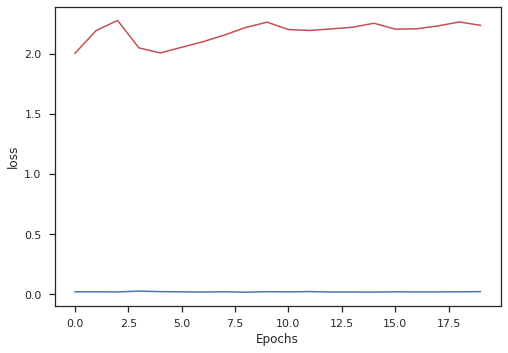

In [ ]:
# Visualization of the training process on the loss function 
plt.plot(history.history["loss"], color="b")
plt.plot(history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

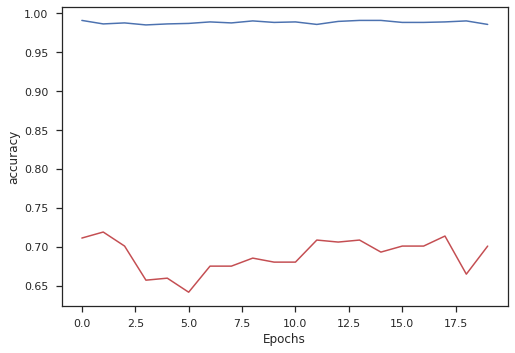

In [ ]:
# Visualization of accuracy training 
plt.plot(history.history["accuracy"], color="b")
plt.plot(history.history["val_accuracy"], color="r")
plt.ylabel("accuracy")
plt.xlabel("Epochs")
plt.show()

In [ ]:
# Pour la GRU je vais avoir la reset gate qui répond à la question est ce qui a dans ma mémoire va être utile 
# pour créer ma nouvelle info, la update gate en deux parties pr créer mon nouvel output je vais garder quelle 
# proportion de ma mémoire et quelle proportion de la nouvelle info. Le neuronne est capable de choisir s'il veut
# passer une proportion de l'ancienne info et une proportion de la noubvelle info ou bien il peut censurer l'une et pas du tout 
# l'autre et parfois ça sera l'inverse donc garder tt l'ancien et pas le nouveau ou bien l'inverse 

In [ ]:
model_gru.save("model_gru.h5")

In [ ]:
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, GRU, LSTM

vocab_size=len(tokenizer.word_index)
model_lstm= tf.keras.Sequential([
                  Embedding(vocab_size+1,64, input_shape=[train_pad.shape[1],],name="embedding"),
                  LSTM(units=32, return_sequences=True), # maintains the sequential nature
                  tf.keras.layers.Bidirectional(LSTM(units=16, return_sequences=False)), # returns the last output
                  Dense(16, activation='relu'),
                  Dropout(0.5),
                  Dense(1, activation="sigmoid")
])
# Bidirectional ça permet de dupliquer le nbre de neurones la moitié des neurones va lire la séquence de gauche
# à droite et l'autre moitié va la lire de droite à gauche  

In [ ]:
model_lstm.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 64)            378240    
                                                                 
 lstm_2 (LSTM)               (None, 25, 32)            12416     
                                                                 
 bidirectional_2 (Bidirectio  (None, 32)               6272      
 nal)                                                            
                                                                 
 dense_15 (Dense)            (None, 16)                528       
                                                                 
 dropout_6 (Dropout)         (None, 16)                0         
                                                                 
 dense_16 (Dense)            (None, 1)                 17        
                                                      

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
# Entrainement du modèle 
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=20, 
                  )

Epoch 1/20
25/25 [==============================] - 2s 27ms/step - loss: 0.0242 - accuracy: 0.9890 - val_loss: 1.7754 - val_accuracy: 0.7062
Epoch 2/20
25/25 [==============================] - 0s 18ms/step - loss: 0.0201 - accuracy: 0.9910 - val_loss: 1.7605 - val_accuracy: 0.7010
Epoch 3/20
25/25 [==============================] - 0s 19ms/step - loss: 0.0251 - accuracy: 0.9839 - val_loss: 1.7012 - val_accuracy: 0.6985
Epoch 4/20
25/25 [==============================] - 0s 17ms/step - loss: 0.0221 - accuracy: 0.9884 - val_loss: 1.7609 - val_accuracy: 0.7088
Epoch 5/20
25/25 [==============================] - 0s 18ms/step - loss: 0.0190 - accuracy: 0.9910 - val_loss: 1.8467 - val_accuracy: 0.7191
Epoch 6/20
25/25 [==============================] - 1s 23ms/step - loss: 0.0208 - accuracy: 0.9903 - val_loss: 1.8979 - val_accuracy: 0.7113
Epoch 7/20
25/25 [==============================] - 1s 41ms/step - loss: 0.0269 - accuracy: 0.9832 - val_loss: 1.8973 - val_accuracy: 0.6907
Epoch 8/20
25

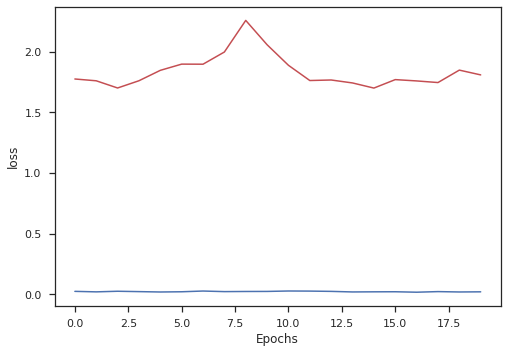

In [ ]:
# Visualization of the training process on the loss function 
plt.plot(history.history["loss"], color="b")
plt.plot(history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

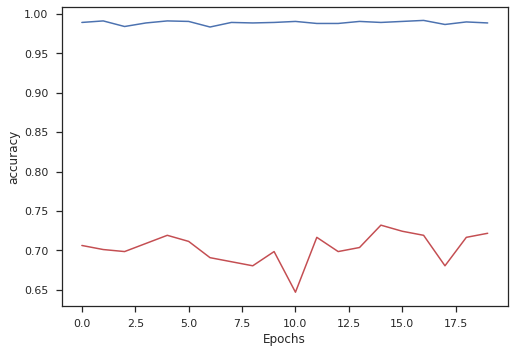

In [ ]:
# Visualization of accuracy training 
plt.plot(history.history["accuracy"], color="b")
plt.plot(history.history["val_accuracy"], color="r")
plt.ylabel("accuracy")
plt.xlabel("Epochs")
plt.show()

In [ ]:
# Lstm ce sont des neurones qui sont capables d'utiliser à la fois de la mémoire de court terme et de la mémoire 
# de long terme on a deux mémoires une mémoire interne au neurone c'est cell state et une autre mémoire qui va 
# communiquer  avec les autres neurones et qui est le hidden state 

In [ ]:
model_lstm.save("model_gru.h5")

In [ ]:
pred=model.predict(train_pad)

In [ ]:
target=df_train.target

In [ ]:
df_eval=pd.DataFrame({"pred":pred.squeeze(),"target":target,"text":df_train.text_clean})
df_eval

,pred,target,text
31,1.000000e+00,1,wholesale market ablaze
33,1.000000e+00,1,africanbaze break newsnigeria flag set ablaze aba
34,4.210218e-09,0,cry set ablaze
35,4.454245e-09,0,plus look sky night ablaze
37,1.000000e+00,1,inec office abia set ablaze
...,...,...,...
7447,9.047938e-09,0,cramer igers 3 word wreck disneys stock cnbc t...
7448,4.412843e-09,0,u night wee barra absolutely wreck
7451,6.909777e-08,0,cramer 3 word wreck dis stock
7456,1.606852e-09,0,day work pretty wreck hahaha shoutout family


In [ ]:
# On prédit si un tweet donné parle d'un véritable désastre ou non. Si oui on prédit un 1 sinon on prédit un 0.
# On peut dire que notre modèle fait de bonnes prédictions puisque pr cry set ablaze et plus look sky night ablaze 
# il déclare que ce sont de fausses déclarations 